# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band8.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.404454 -0.065860  0.279623 -0.018950  0.353436  0.223552   
      201547  0.164046 -0.279912  0.125948 -0.092586  0.311381 -0.091313   
      201548  0.226342 -0.004646 -0.153378  0.161025 -0.055631 -0.126989   
      201549  0.030989  0.038862 -0.250168  0.138053  0.119237 -0.361689   
      201550 -0.225796  0.247388  0.193340  0.175360 -0.112679 -0.070447   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.238083  0.301491  0.017513  0.058784  ... -0.211455 -0.119413   
      201547 -0.261746 -0.603773  0.018815  0.188192  ... -0.179405 -0.000805   
      201548 -0.085751 -0.181040  0.069509 -0.042110  ... -0.263966  0.463458   
      201549 -0.227923 -0.686621  0.141110 -0.393854  ... -0.580254  0.053762   
      201550  0.165248 -0.520760  0.329034  0.121354  ... -0.670146  0.293254   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.329139 -0.489306 -0.582317  0.128176  0.561558 -0.120706   
      201547  0.151309 -0.491851 -0.211698 -0.004022 -0.153898 -0.101417   
      201548 -0.309870 -0.283341  0.397133  0.060761  0.106624 -0.538396   
      201549 -0.634662 -0.136573  0.148543  0.143810  0.271836 -0.561334   
      201550 -0.052660 -0.033099 -0.004069  0.198201 -0.417523 -0.008597   

                  1023    Labels  
41001 201546 -0.311336 -0.861740  
      201547 -0.787966 -0.854589  
      201548 -0.081292 -0.856973  
      201549 -0.279745 -0.856973  
      201550 -0.472354 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -0.652144 -0.000483 -0.371819  0.097266 -0.139232 -0.246002   
      201821  0.261872  0.020454  0.043720  0.017301  0.163034 -0.061027   
      201822 -0.457974  0.168361  0.048842  0.409691  0.166140 -0.261032   
      201823 -0.001343 -0.242898  0.037339  0.412419 -0.025480  0.159335   
      201824  0.076634 -0.049523 -0.061193 -0.182151  0.707878 -0.140500   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.256809  0.092985  0.124264 -0.153187  ...  0.325657  0.525835   
      201821 -0.226625  0.165741 -0.206911 -0.183202  ... -0.268065  0.155530   
      201822 -0.183974 -0.008353  0.134526 -0.464827  ...  0.134037 -0.397434   
      201823  0.201330 -0.311470  0.058695  0.322268  ...  0.314682  0.226647   
      201824  0.611162 -0.404637  0.123876 -0.362569  ... -0.712207 -0.027136   

                  1017      1018      1019      1020      1021      1022  \
41001 201820 -0.012009  0.018735 -0.414727 -0.117460 -0.063599  0.171647   
      201821 -0.236598  0.397119  0.031110  0.281907  0.572680 -0.732058   
      201822 -0.328328 -0.830100  0.007346 -0.207447 -0.124675 -0.096934   
      201823 -0.151675 -0.052633  0.391067  0.690685 -0.491931  0.201485   
      201824 -0.066190  0.387704  0.504935  0.207604  0.561364  0.411014   

                  1023    Labels  
41001 201820  0.266653 -0.949940  
      201821 -0.780826 -0.961859  
      201822  0.041098 -0.940405  
      201823  0.437803 -0.961859  
      201824  0.109880 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

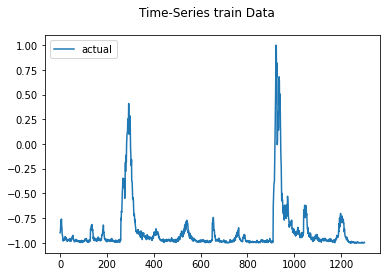

2023-03-14 15:36:08.217058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 15:36:08.217114: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 15:36:08.217146: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 15:36:08.217419: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 15:36:08.344096: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 48.816
Test RMSE: 60.683
Test sMAPE: 105.529
Test R Squared: -2.810
{'mae': 48.815950771263154, 'rmse': 60.68323076358295, 'smape': 105.52922063660543, 'r2': -2.8104774041360803}


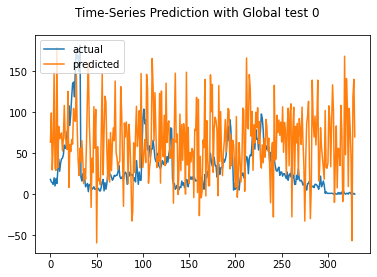

Test MAE: 50.385
Test RMSE: 59.080
Test sMAPE: 105.025
Test R Squared: -2.612
{'mae': 50.38458769538186, 'rmse': 59.0800130031947, 'smape': 105.02498709155746, 'r2': -2.611795612673845}


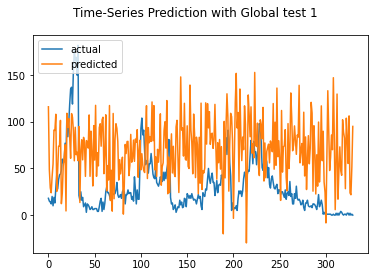

Test MAE: 53.340
Test RMSE: 63.067
Test sMAPE: 107.048
Test R Squared: -3.116
{'mae': 53.33963434912942, 'rmse': 63.06720994551929, 'smape': 107.04795859152603, 'r2': -3.115752386291672}


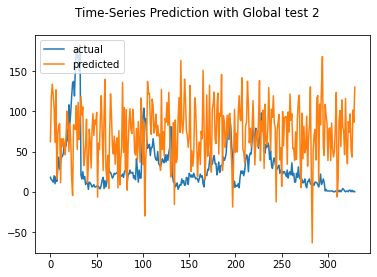

Test MAE: 34.105
Test RMSE: 43.566
Test sMAPE: 97.625
Test R Squared: -0.964
{'mae': 34.105355670325686, 'rmse': 43.565607747551354, 'smape': 97.62533436128047, 'r2': -0.9639460590183653}


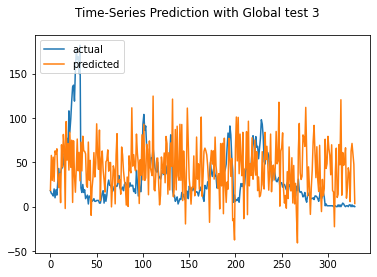

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 46.064
Test RMSE: 57.658
Test sMAPE: 108.700
Test R Squared: -2.440
{'mae': 46.06437310161012, 'rmse': 57.658149414849355, 'smape': 108.70034772121724, 'r2': -2.4400392686495014}


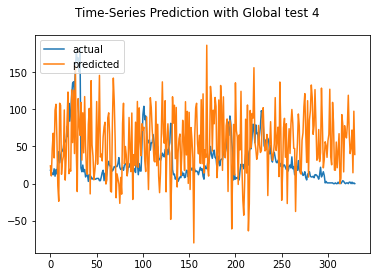

Test MAE: 39.421
Test RMSE: 49.625
Test sMAPE: 97.673
Test R Squared: -1.548
{'mae': 39.421245738593015, 'rmse': 49.62483871726738, 'smape': 97.6731033907741, 'r2': -1.548239352612049}


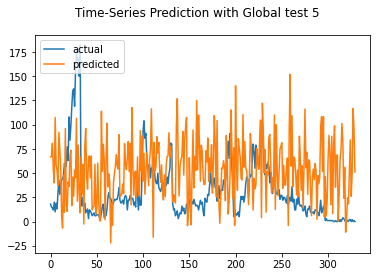

Test MAE: 49.863
Test RMSE: 57.850
Test sMAPE: 104.111
Test R Squared: -2.463
{'mae': 49.86291947021629, 'rmse': 57.84950391405471, 'smape': 104.11139831249443, 'r2': -2.462910599714848}


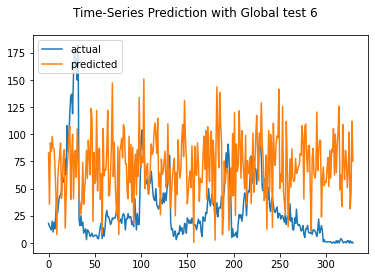

Test MAE: 41.041
Test RMSE: 50.000
Test sMAPE: 97.374
Test R Squared: -1.587
{'mae': 41.04066970447699, 'rmse': 49.99997303718431, 'smape': 97.37420247304951, 'r2': -1.5869113241760684}


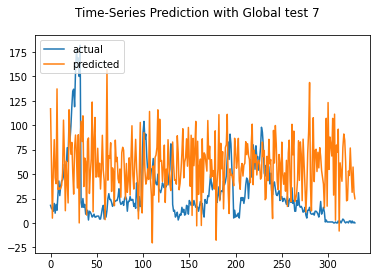

Test MAE: 58.713
Test RMSE: 67.468
Test sMAPE: 109.407
Test R Squared: -3.710
{'mae': 58.71337625257897, 'rmse': 67.46848293047464, 'smape': 109.40667504010185, 'r2': -3.7102492755717673}


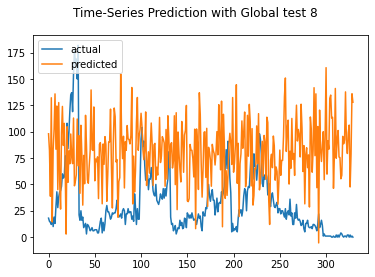

Test MAE: 46.376
Test RMSE: 55.534
Test sMAPE: 101.675
Test R Squared: -2.191
{'mae': 46.37632439046195, 'rmse': 55.533670277045324, 'smape': 101.67520703562938, 'r2': -2.191205387102749}


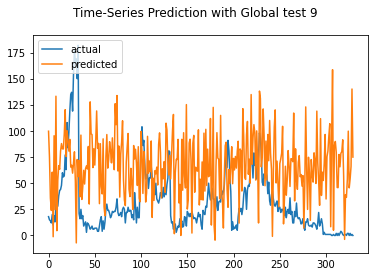

Test MAE: 38.819
Test RMSE: 48.377
Test sMAPE: 106.102
Test R Squared: -1.422
{'mae': 38.81907455361251, 'rmse': 48.37680118150943, 'smape': 106.10192583953857, 'r2': -1.4216774508846801}


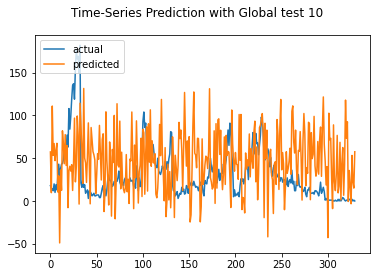

Test MAE: 36.350
Test RMSE: 45.920
Test sMAPE: 105.880
Test R Squared: -1.182
{'mae': 36.34983324390469, 'rmse': 45.92045868387221, 'smape': 105.88006289105125, 'r2': -1.1819984438681366}


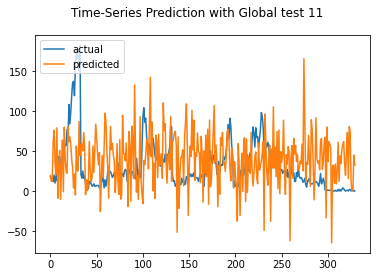

Test MAE: 43.701
Test RMSE: 52.712
Test sMAPE: 99.623
Test R Squared: -1.875
{'mae': 43.70129055507255, 'rmse': 52.712011913467016, 'smape': 99.62282185314312, 'r2': -1.875154500309737}


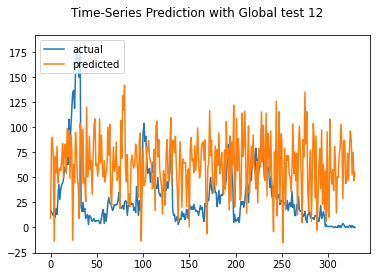

Test MAE: 44.831
Test RMSE: 54.440
Test sMAPE: 103.890
Test R Squared: -2.067
{'mae': 44.83103568770669, 'rmse': 54.44029754532718, 'smape': 103.88961909348775, 'r2': -2.066782540028749}


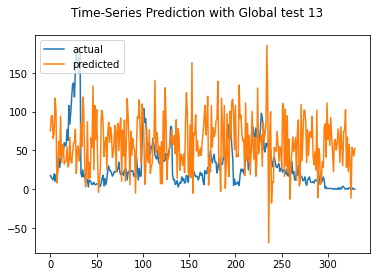

Test MAE: 48.914
Test RMSE: 58.250
Test sMAPE: 107.724
Test R Squared: -2.511
{'mae': 48.91437669866013, 'rmse': 58.24955078822983, 'smape': 107.72445693426134, 'r2': -2.5109703562792056}


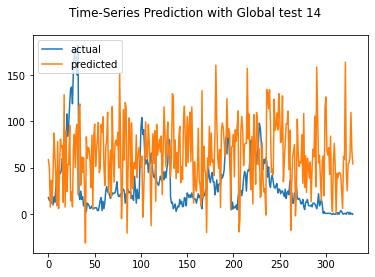

Test MAE: 64.331
Test RMSE: 72.811
Test sMAPE: 112.469
Test R Squared: -4.486
{'mae': 64.33105144898097, 'rmse': 72.81084675517391, 'smape': 112.4685291168731, 'r2': -4.485726673836956}


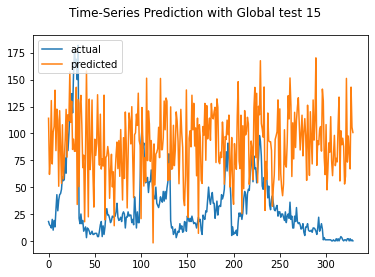

Test MAE: 45.421
Test RMSE: 54.016
Test sMAPE: 99.625
Test R Squared: -2.019
{'mae': 45.42139788504803, 'rmse': 54.01637338423084, 'smape': 99.62516713049567, 'r2': -2.019206702679432}


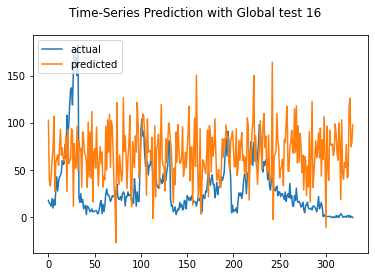

Test MAE: 42.660
Test RMSE: 52.137
Test sMAPE: 101.964
Test R Squared: -1.813
{'mae': 42.66036881253575, 'rmse': 52.13726602534737, 'smape': 101.96385661391037, 'r2': -1.8127977723320492}


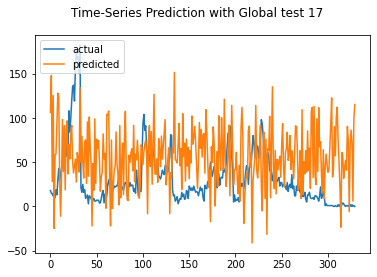

Test MAE: 32.820
Test RMSE: 42.822
Test sMAPE: 103.408
Test R Squared: -0.897
{'mae': 32.819924738912874, 'rmse': 42.82158191047214, 'smape': 103.40838516740473, 'r2': -0.8974372203419547}


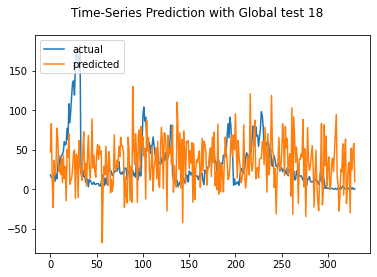

Test MAE: 60.435
Test RMSE: 68.595
Test sMAPE: 110.336
Test R Squared: -3.869
{'mae': 60.43539539828445, 'rmse': 68.59539187273222, 'smape': 110.33590795520065, 'r2': -3.8689115447863864}


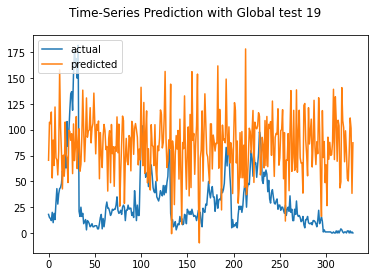

Test MAE: 63.342
Test RMSE: 71.655
Test sMAPE: 112.778
Test R Squared: -4.313
{'mae': 63.34234292868412, 'rmse': 71.65498109836034, 'smape': 112.77821658321861, 'r2': -4.312938309931564}


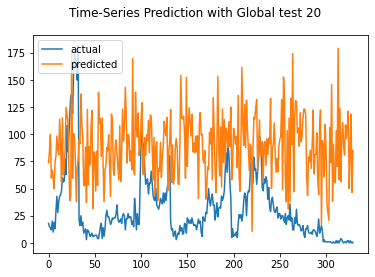

Test MAE: 60.661
Test RMSE: 71.400
Test sMAPE: 110.049
Test R Squared: -4.275
{'mae': 60.66073865168023, 'rmse': 71.39974841703237, 'smape': 110.04943523962108, 'r2': -4.27515669606579}


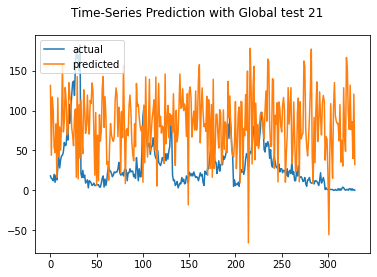

Test MAE: 50.339
Test RMSE: 59.524
Test sMAPE: 103.124
Test R Squared: -2.666
{'mae': 50.33894828016108, 'rmse': 59.52447847759804, 'smape': 103.12397977661648, 'r2': -2.6663439061721865}


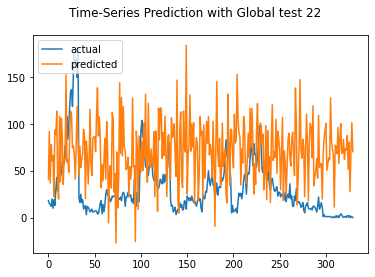

Test MAE: 56.088
Test RMSE: 64.014
Test sMAPE: 107.895
Test R Squared: -3.240
{'mae': 56.08814738880504, 'rmse': 64.01435820136652, 'smape': 107.89526697235164, 'r2': -3.240302041831008}


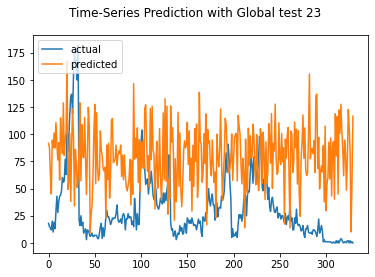

Test MAE: 74.651
Test RMSE: 82.295
Test sMAPE: 120.098
Test R Squared: -6.008
{'mae': 74.65063489856142, 'rmse': 82.29477587125878, 'smape': 120.09792773531687, 'r2': -6.0078780421771025}


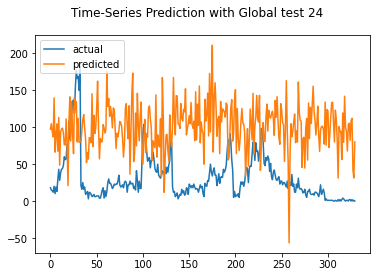

Test MAE: 59.876
Test RMSE: 67.282
Test sMAPE: 111.451
Test R Squared: -3.684
{'mae': 59.87568074717666, 'rmse': 67.28193849948961, 'smape': 111.45054459485047, 'r2': -3.6842384329076454}


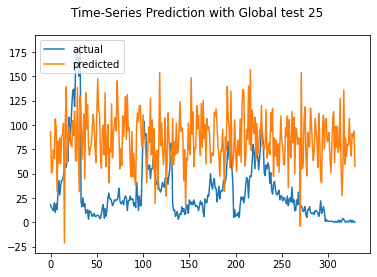

Test MAE: 39.737
Test RMSE: 49.158
Test sMAPE: 99.813
Test R Squared: -1.501
{'mae': 39.73708742224809, 'rmse': 49.15796211496347, 'smape': 99.8132289064657, 'r2': -1.5005166042244449}


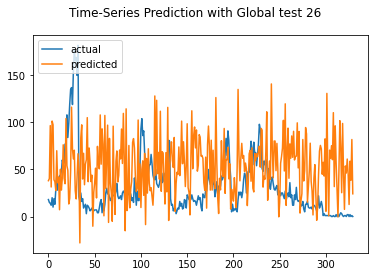

Test MAE: 32.998
Test RMSE: 41.526
Test sMAPE: 96.364
Test R Squared: -0.784
{'mae': 32.99815977649255, 'rmse': 41.52592891209738, 'smape': 96.36372645615748, 'r2': -0.7843527477904144}


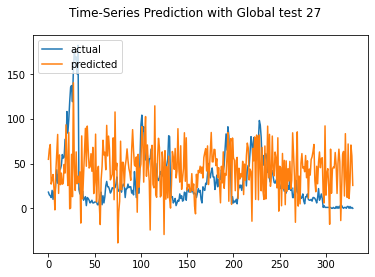

Test MAE: 54.363
Test RMSE: 61.744
Test sMAPE: 107.924
Test R Squared: -2.945
{'mae': 54.362804080500744, 'rmse': 61.743694661442696, 'smape': 107.92397235007365, 'r2': -2.944820339318481}


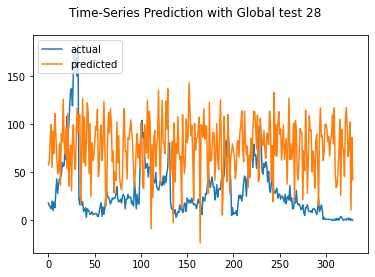

Test MAE: 53.563
Test RMSE: 62.411
Test sMAPE: 107.062
Test R Squared: -3.030
{'mae': 53.56293057293603, 'rmse': 62.4106099251062, 'smape': 107.06172519742428, 'r2': -3.030499349492228}


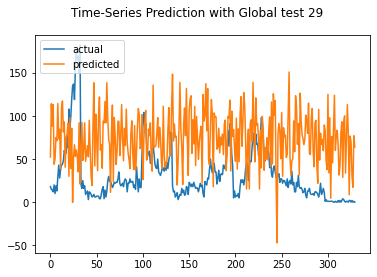

Test MAE: 41.143
Test RMSE: 50.473
Test sMAPE: 103.647
Test R Squared: -1.636
{'mae': 41.14298660321669, 'rmse': 50.472608994345414, 'smape': 103.64654527655681, 'r2': -1.6360491938040393}


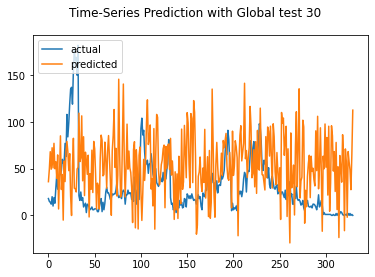

Test MAE: 36.606
Test RMSE: 46.667
Test sMAPE: 96.536
Test R Squared: -1.254
{'mae': 36.606453678102206, 'rmse': 46.66692903692899, 'smape': 96.53620838964696, 'r2': -1.2535149676650241}


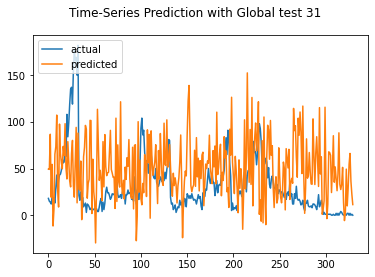

Test MAE: 50.408
Test RMSE: 58.808
Test sMAPE: 105.841
Test R Squared: -2.579
{'mae': 50.40814590923714, 'rmse': 58.808030420567896, 'smape': 105.84069574801856, 'r2': -2.5786174100732553}


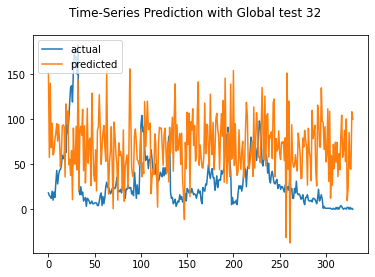

Test MAE: 52.454
Test RMSE: 61.898
Test sMAPE: 105.881
Test R Squared: -2.965
{'mae': 52.45368985118288, 'rmse': 61.898259137528925, 'smape': 105.88058967763835, 'r2': -2.964595387348772}


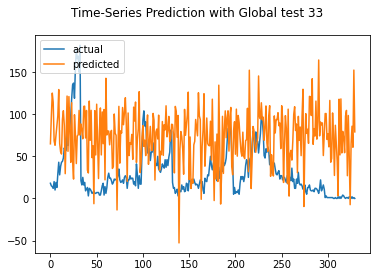

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 38.652
Test RMSE: 51.701
Test sMAPE: 102.770
Test R Squared: -1.766
{'mae': 38.652495206034544, 'rmse': 51.70092048605469, 'smape': 102.7699225865559, 'r2': -1.7659132347445157}


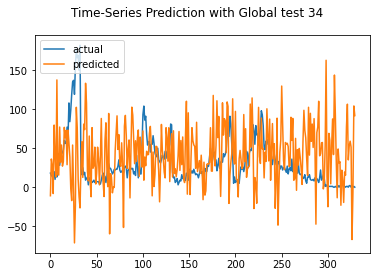

Test MAE: 39.082
Test RMSE: 49.679
Test sMAPE: 102.105
Test R Squared: -1.554
{'mae': 39.08240809747667, 'rmse': 49.67885274997024, 'smape': 102.10476516806467, 'r2': -1.5537896211717857}


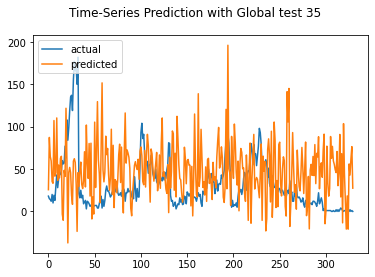

Test MAE: 38.431
Test RMSE: 47.987
Test sMAPE: 98.066
Test R Squared: -1.383
{'mae': 38.43085953358448, 'rmse': 47.98671247047548, 'smape': 98.06608447118779, 'r2': -1.3827802803480682}


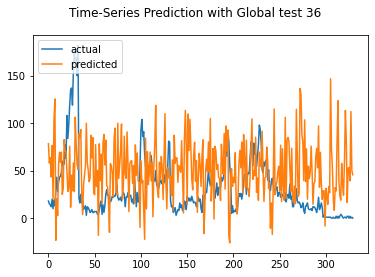

Test MAE: 57.289
Test RMSE: 66.728
Test sMAPE: 107.873
Test R Squared: -3.607
{'mae': 57.28894097389597, 'rmse': 66.72820895397393, 'smape': 107.87347153021224, 'r2': -3.607453256983277}


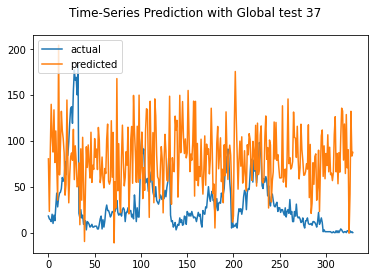

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 38.749
Test RMSE: 49.002
Test sMAPE: 108.867
Test R Squared: -1.485
{'mae': 38.74863679987011, 'rmse': 49.0015709487847, 'smape': 108.86713619783548, 'r2': -1.4846316230821022}


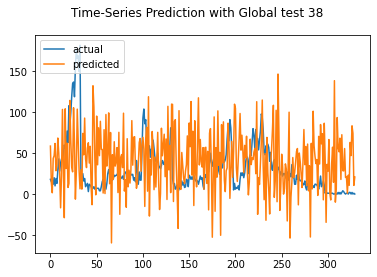

Test MAE: 57.821
Test RMSE: 68.062
Test sMAPE: 107.539
Test R Squared: -3.793
{'mae': 57.820797810410006, 'rmse': 68.06173572202873, 'smape': 107.53867321580908, 'r2': -3.793448241996699}


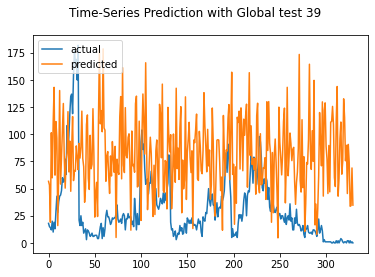

Test MAE: 47.030
Test RMSE: 55.320
Test sMAPE: 105.525
Test R Squared: -2.167
{'mae': 47.029841375531575, 'rmse': 55.31959693277152, 'smape': 105.52472357335725, 'r2': -2.1666496433292863}


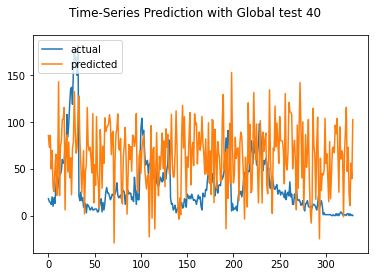

Test MAE: 42.121
Test RMSE: 52.088
Test sMAPE: 102.121
Test R Squared: -1.807
{'mae': 42.12096051013831, 'rmse': 52.08800828589707, 'smape': 102.12096058550631, 'r2': -1.8074853875286574}


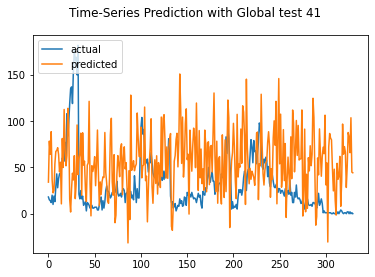

Test MAE: 50.016
Test RMSE: 58.068
Test sMAPE: 103.791
Test R Squared: -2.489
{'mae': 50.016066486185245, 'rmse': 58.06829245150161, 'smape': 103.79145514965437, 'r2': -2.489153793251663}


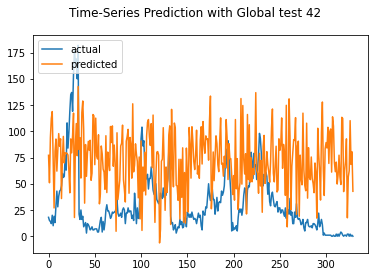

Test MAE: 48.642
Test RMSE: 57.184
Test sMAPE: 104.377
Test R Squared: -2.384
{'mae': 48.64169778119434, 'rmse': 57.18365414837203, 'smape': 104.3771632808896, 'r2': -2.383652930649028}


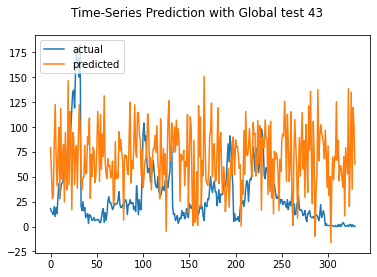

Test MAE: 51.113
Test RMSE: 59.328
Test sMAPE: 104.109
Test R Squared: -2.642
{'mae': 51.1126794237079, 'rmse': 59.32812656499568, 'smape': 104.1094653455312, 'r2': -2.6421956461950638}


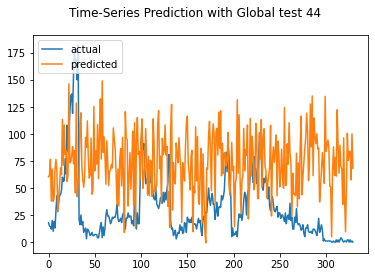

Test MAE: 41.699
Test RMSE: 51.509
Test sMAPE: 102.310
Test R Squared: -1.745
{'mae': 41.69932915667693, 'rmse': 51.50921678954271, 'smape': 102.30997677505225, 'r2': -1.7454396050216152}


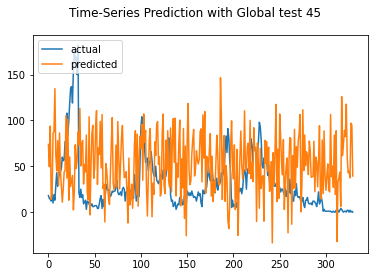

Test MAE: 75.838
Test RMSE: 83.638
Test sMAPE: 119.761
Test R Squared: -6.238
{'mae': 75.83788913958, 'rmse': 83.63776937310405, 'smape': 119.76114464633284, 'r2': -6.23847176873461}


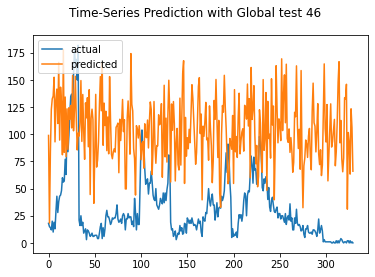

Test MAE: 54.424
Test RMSE: 63.328
Test sMAPE: 107.149
Test R Squared: -3.150
{'mae': 54.42353071769079, 'rmse': 63.327722894304365, 'smape': 107.14887613021472, 'r2': -3.1498246493347164}


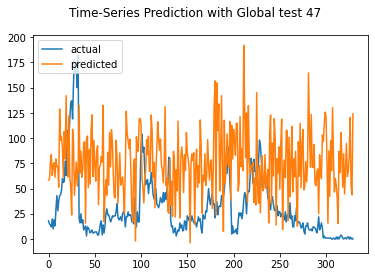

Test MAE: 59.911
Test RMSE: 70.128
Test sMAPE: 110.905
Test R Squared: -4.089
{'mae': 59.91139464233861, 'rmse': 70.12774977608046, 'smape': 110.90521228865128, 'r2': -4.0888753023370805}


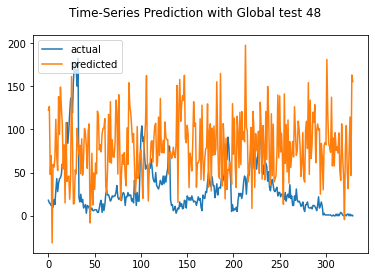

Test MAE: 31.231
Test RMSE: 41.562
Test sMAPE: 96.178
Test R Squared: -0.787
{'mae': 31.23137054027933, 'rmse': 41.56204414360387, 'smape': 96.17839097399988, 'r2': -0.7874578118843949}


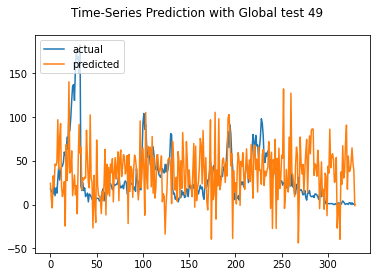

Test MAE: 38.854
Test RMSE: 48.296
Test sMAPE: 100.830
Test R Squared: -1.414
{'mae': 38.85390208923455, 'rmse': 48.29635788923619, 'smape': 100.83038503676357, 'r2': -1.4136303814478621}


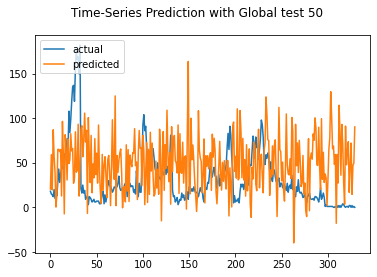

Test MAE: 42.104
Test RMSE: 51.130
Test sMAPE: 98.897
Test R Squared: -1.705
{'mae': 42.10442605271484, 'rmse': 51.12955571060112, 'smape': 98.8969788686271, 'r2': -1.7051169120709941}


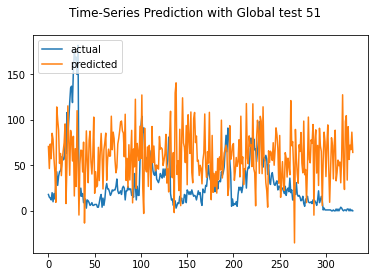

Test MAE: 46.363
Test RMSE: 56.753
Test sMAPE: 103.792
Test R Squared: -2.333
{'mae': 46.363322138786316, 'rmse': 56.75312586911798, 'smape': 103.79213857820226, 'r2': -2.3328945653837163}


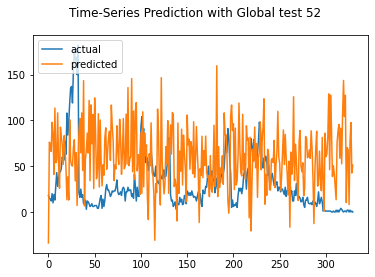

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 47.289
Test RMSE: 58.631
Test sMAPE: 105.700
Test R Squared: -2.557
{'mae': 47.28893778053197, 'rmse': 58.63078671367472, 'smape': 105.69968353763953, 'r2': -2.5570784617498385}


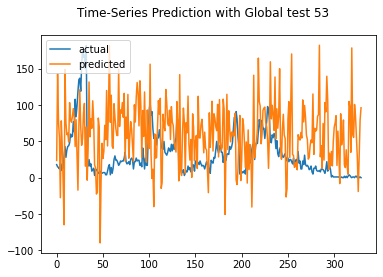

Test MAE: 43.224
Test RMSE: 53.658
Test sMAPE: 107.005
Test R Squared: -1.979
{'mae': 43.22392548846476, 'rmse': 53.658185953603386, 'smape': 107.00522034999229, 'r2': -1.979298198845945}


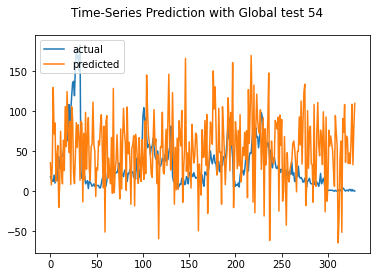

Test MAE: 73.570
Test RMSE: 81.220
Test sMAPE: 119.279
Test R Squared: -5.826
{'mae': 73.57041302738767, 'rmse': 81.22048604193954, 'smape': 119.27915717564024, 'r2': -5.826108229299245}


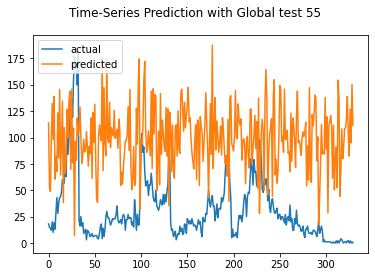

Test MAE: 52.334
Test RMSE: 61.577
Test sMAPE: 105.579
Test R Squared: -2.924
{'mae': 52.33445886409644, 'rmse': 61.57735913540109, 'smape': 105.57868359316478, 'r2': -2.9235945306641655}


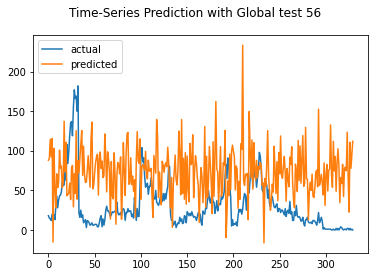

Test MAE: 42.826
Test RMSE: 53.106
Test sMAPE: 106.699
Test R Squared: -1.918
{'mae': 42.826048867088375, 'rmse': 53.10618524857537, 'smape': 106.69863566915761, 'r2': -1.9183153118238603}


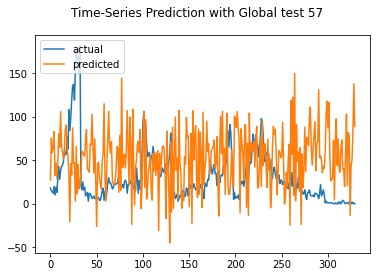

Test MAE: 39.129
Test RMSE: 47.886
Test sMAPE: 104.853
Test R Squared: -1.373
{'mae': 39.12898168843804, 'rmse': 47.885735824834406, 'smape': 104.85292250349201, 'r2': -1.3727628401271277}


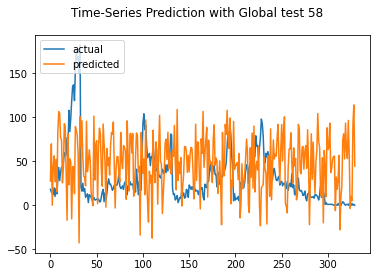

Test MAE: 40.386
Test RMSE: 50.311
Test sMAPE: 99.475
Test R Squared: -1.619
{'mae': 40.3859749360518, 'rmse': 50.31084724422464, 'smape': 99.47450985091841, 'r2': -1.619179504407429}


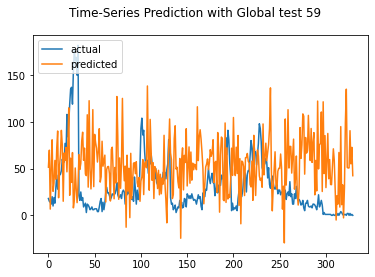

Test MAE: 62.624
Test RMSE: 69.801
Test sMAPE: 113.367
Test R Squared: -4.042
{'mae': 62.62396430391254, 'rmse': 69.80120418027505, 'smape': 113.36715918552427, 'r2': -4.041593565664646}


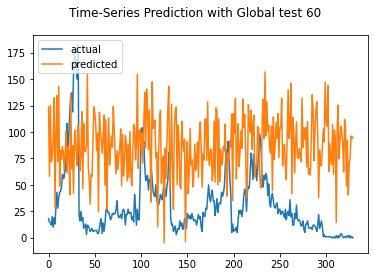

Test MAE: 50.014
Test RMSE: 59.909
Test sMAPE: 105.724
Test R Squared: -2.714
{'mae': 50.013555210648164, 'rmse': 59.909022040830514, 'smape': 105.72439154990263, 'r2': -2.7138679851850167}


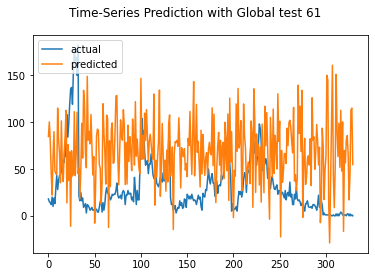

Test MAE: 39.159
Test RMSE: 47.960
Test sMAPE: 101.831
Test R Squared: -1.380
{'mae': 39.158801217783584, 'rmse': 47.96019249755043, 'smape': 101.83110595219301, 'r2': -1.3801473095165608}


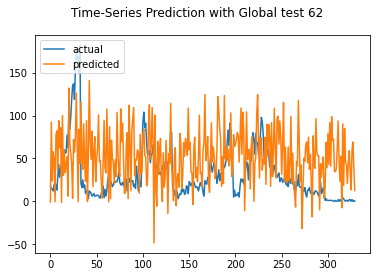

Test MAE: 42.545
Test RMSE: 52.434
Test sMAPE: 106.261
Test R Squared: -1.845
{'mae': 42.545287132082564, 'rmse': 52.43416757207176, 'smape': 106.26086980810989, 'r2': -1.844924576326394}


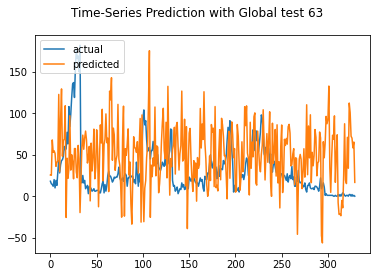

Test MAE: 54.124
Test RMSE: 62.357
Test sMAPE: 106.615
Test R Squared: -3.024
{'mae': 54.12422099817883, 'rmse': 62.35692116441045, 'smape': 106.61460843214033, 'r2': -3.02356785372796}


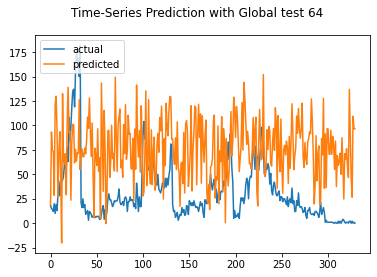

Test MAE: 59.501
Test RMSE: 66.836
Test sMAPE: 112.893
Test R Squared: -3.622
{'mae': 59.501248158830585, 'rmse': 66.83591852792577, 'smape': 112.89347899900956, 'r2': -3.622339535530946}


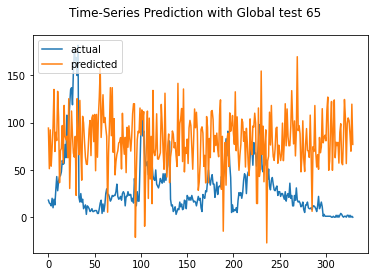

Test MAE: 39.892
Test RMSE: 49.790
Test sMAPE: 104.511
Test R Squared: -1.565
{'mae': 39.89171093702316, 'rmse': 49.790333498006994, 'smape': 104.51069458692483, 'r2': -1.5652640332049756}


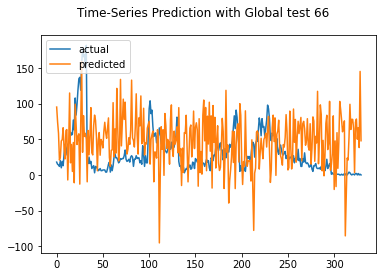

Test MAE: 41.085
Test RMSE: 50.761
Test sMAPE: 101.654
Test R Squared: -1.666
{'mae': 41.08477463722229, 'rmse': 50.761059772856925, 'smape': 101.65416846701635, 'r2': -1.6662653135770906}


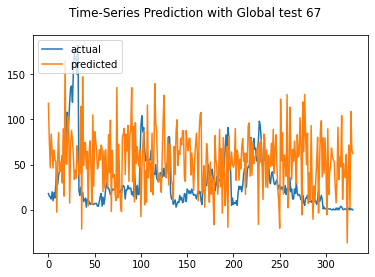

Test MAE: 58.828
Test RMSE: 67.199
Test sMAPE: 111.484
Test R Squared: -3.673
{'mae': 58.827993157415676, 'rmse': 67.19854542717076, 'smape': 111.48394113424098, 'r2': -3.6726338044837776}


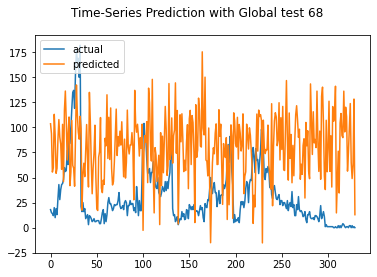

Test MAE: 51.575
Test RMSE: 61.684
Test sMAPE: 105.499
Test R Squared: -2.937
{'mae': 51.574761694218175, 'rmse': 61.68408338644999, 'smape': 105.49886448970493, 'r2': -2.9372068573526664}


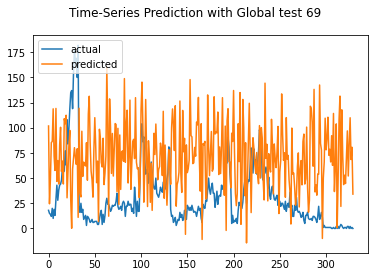

Test MAE: 41.610
Test RMSE: 50.453
Test sMAPE: 102.251
Test R Squared: -1.634
{'mae': 41.60971295273665, 'rmse': 50.45331683403078, 'smape': 102.25123585221745, 'r2': -1.634034423199533}


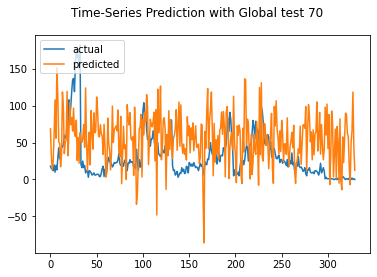

Test MAE: 29.811
Test RMSE: 38.921
Test sMAPE: 96.038
Test R Squared: -0.568
{'mae': 29.810566410873875, 'rmse': 38.921147864752825, 'smape': 96.0379236065364, 'r2': -0.5675206894062346}


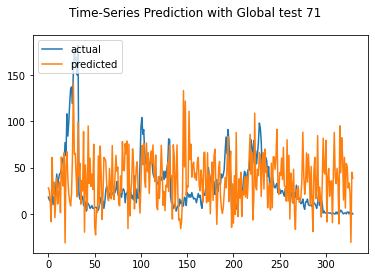

Test MAE: 39.049
Test RMSE: 48.679
Test sMAPE: 92.723
Test R Squared: -1.452
{'mae': 39.04852106787941, 'rmse': 48.679447201098384, 'smape': 92.7234486487395, 'r2': -1.4520723333370742}


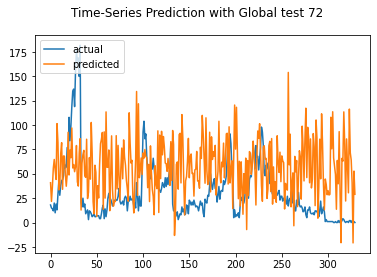

Test MAE: 66.170
Test RMSE: 74.293
Test sMAPE: 115.274
Test R Squared: -4.711
{'mae': 66.16991175503442, 'rmse': 74.29268993517684, 'smape': 115.27408669004676, 'r2': -4.7112894138969645}


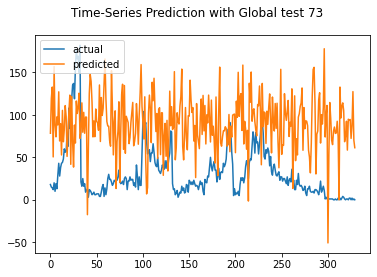

Test MAE: 34.591
Test RMSE: 43.245
Test sMAPE: 98.385
Test R Squared: -0.935
{'mae': 34.590624490560906, 'rmse': 43.24538255030154, 'smape': 98.38486111805236, 'r2': -0.9351805400309594}


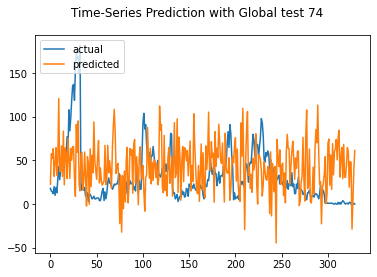

Test MAE: 46.623
Test RMSE: 54.666
Test sMAPE: 101.786
Test R Squared: -2.092
{'mae': 46.62295791091341, 'rmse': 54.665839638895164, 'smape': 101.78647152135841, 'r2': -2.092246080564061}


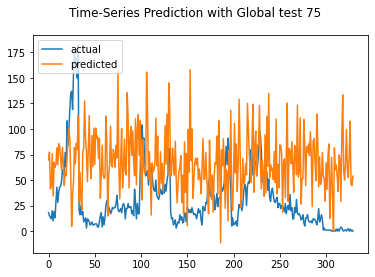

Test MAE: 48.146
Test RMSE: 57.452
Test sMAPE: 103.732
Test R Squared: -2.416
{'mae': 48.146076542139056, 'rmse': 57.452294713062685, 'smape': 103.73193234632292, 'r2': -2.4155194348519653}


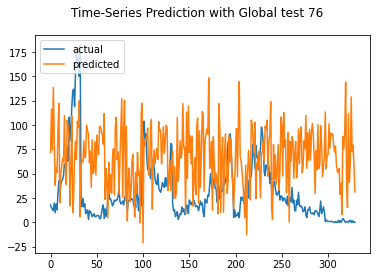

Test MAE: 56.022
Test RMSE: 65.255
Test sMAPE: 107.733
Test R Squared: -3.406
{'mae': 56.022159952557445, 'rmse': 65.25519729475161, 'smape': 107.73313789134764, 'r2': -3.406281263936407}


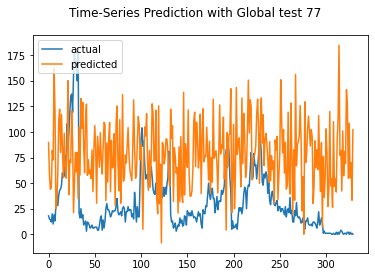

Test MAE: 52.835
Test RMSE: 62.720
Test sMAPE: 106.808
Test R Squared: -3.071
{'mae': 52.83453057588953, 'rmse': 62.71960249613598, 'smape': 106.80752171959837, 'r2': -3.0705078451062713}


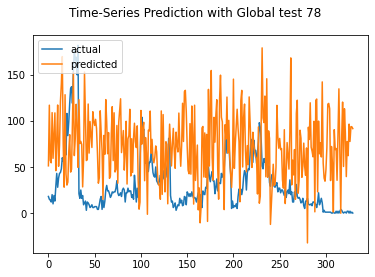

Test MAE: 39.943
Test RMSE: 48.449
Test sMAPE: 97.762
Test R Squared: -1.429
{'mae': 39.94342949390411, 'rmse': 48.44920483526094, 'smape': 97.76178913003898, 'r2': -1.4289317340256997}


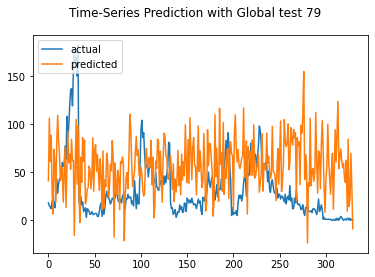

Test MAE: 60.181
Test RMSE: 69.371
Test sMAPE: 110.337
Test R Squared: -3.980
{'mae': 60.18095638101751, 'rmse': 69.37140144985871, 'smape': 110.33688158610559, 'r2': -3.979697231276811}


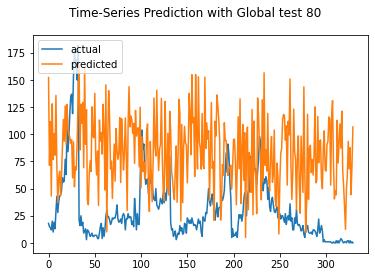

Test MAE: 61.653
Test RMSE: 70.561
Test sMAPE: 112.098
Test R Squared: -4.152
{'mae': 61.65329459219268, 'rmse': 70.56136379764155, 'smape': 112.09828006229468, 'r2': -4.152000944963015}


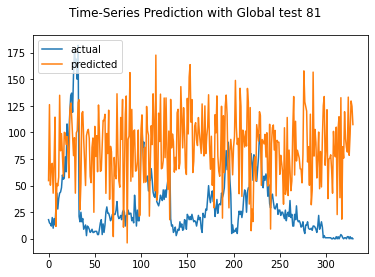

Test MAE: 41.583
Test RMSE: 49.448
Test sMAPE: 96.478
Test R Squared: -1.530
{'mae': 41.58254918040651, 'rmse': 49.44835843900641, 'smape': 96.47815468796038, 'r2': -1.5301470284806604}


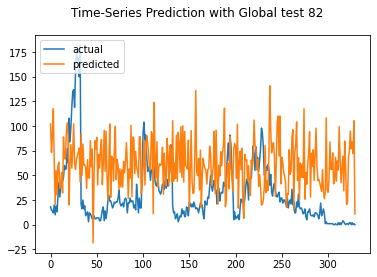

Test MAE: 52.779
Test RMSE: 62.133
Test sMAPE: 106.042
Test R Squared: -2.995
{'mae': 52.77935310782808, 'rmse': 62.13268524165033, 'smape': 106.04226674495227, 'r2': -2.994682327510313}


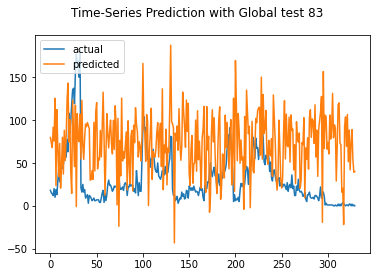

Test MAE: 34.709
Test RMSE: 45.816
Test sMAPE: 103.950
Test R Squared: -1.172
{'mae': 34.708988071029836, 'rmse': 45.816497125918254, 'smape': 103.94962145733584, 'r2': -1.1721297629950724}


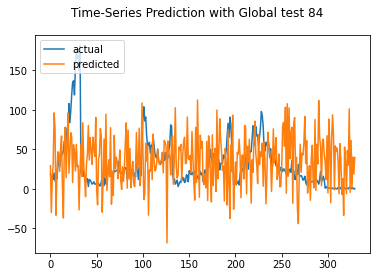

Test MAE: 37.294
Test RMSE: 46.452
Test sMAPE: 100.529
Test R Squared: -1.233
{'mae': 37.29418398828218, 'rmse': 46.45214317015283, 'smape': 100.52867301188402, 'r2': -1.2328189711465898}


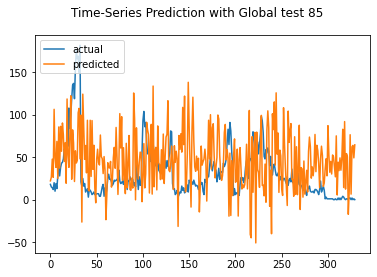

Test MAE: 37.854
Test RMSE: 48.968
Test sMAPE: 102.425
Test R Squared: -1.481
{'mae': 37.853693155628264, 'rmse': 48.96839031826093, 'smape': 102.42470138321853, 'r2': -1.4812679051336053}


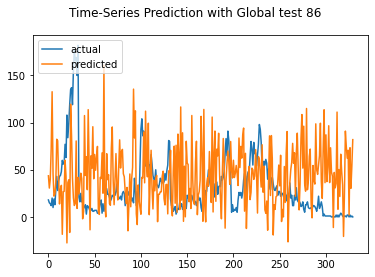

Test MAE: 40.624
Test RMSE: 50.901
Test sMAPE: 104.195
Test R Squared: -1.681
{'mae': 40.62433658052574, 'rmse': 50.900600146969644, 'smape': 104.194734005997, 'r2': -1.6809444018188606}


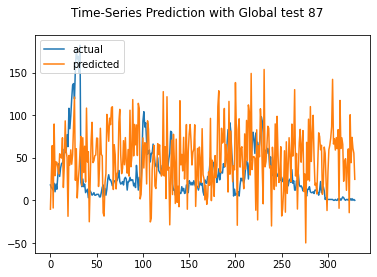

Test MAE: 52.044
Test RMSE: 60.375
Test sMAPE: 106.357
Test R Squared: -2.772
{'mae': 52.04428478009773, 'rmse': 60.375074510126126, 'smape': 106.3567830279734, 'r2': -2.7718756023084072}


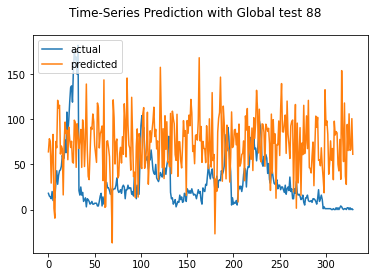

Test MAE: 46.782
Test RMSE: 56.568
Test sMAPE: 101.923
Test R Squared: -2.311
{'mae': 46.782364244533305, 'rmse': 56.56763439982302, 'smape': 101.92313492893528, 'r2': -2.311143755994366}


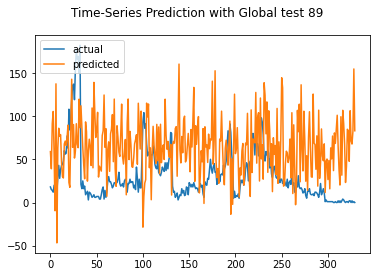

Test MAE: 49.366
Test RMSE: 57.607
Test sMAPE: 102.452
Test R Squared: -2.434
{'mae': 49.36553895690224, 'rmse': 57.60678089451059, 'smape': 102.4519266421463, 'r2': -2.4339124327298087}


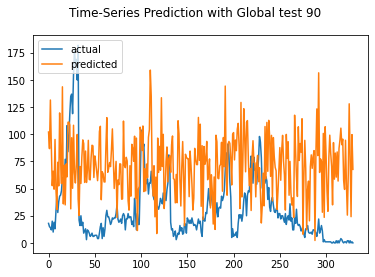

Test MAE: 48.616
Test RMSE: 57.052
Test sMAPE: 102.666
Test R Squared: -2.368
{'mae': 48.616234669902106, 'rmse': 57.05209997798155, 'smape': 102.665681843908, 'r2': -2.3681022760620456}


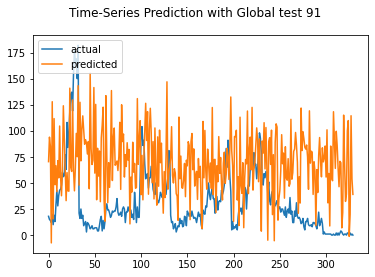

Test MAE: 45.952
Test RMSE: 55.800
Test sMAPE: 103.195
Test R Squared: -2.222
{'mae': 45.952426024278004, 'rmse': 55.79969743161828, 'smape': 103.1949873556592, 'r2': -2.2218527645532533}


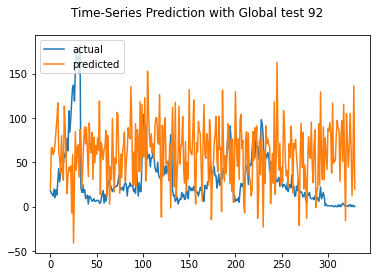

Test MAE: 46.690
Test RMSE: 55.422
Test sMAPE: 103.721
Test R Squared: -2.178
{'mae': 46.69042290124026, 'rmse': 55.422007683131696, 'smape': 103.7207449212075, 'r2': -2.178385055889933}


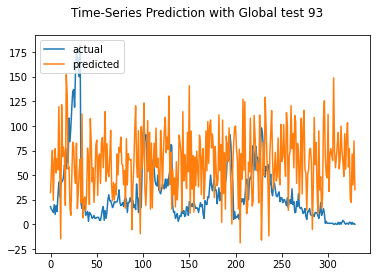

Test MAE: 55.924
Test RMSE: 64.423
Test sMAPE: 107.417
Test R Squared: -3.295
{'mae': 55.9244724017201, 'rmse': 64.42290031511972, 'smape': 107.41748831688388, 'r2': -3.294598294880964}


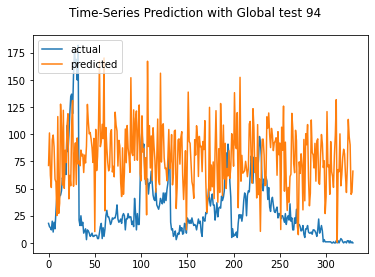

Test MAE: 34.656
Test RMSE: 44.602
Test sMAPE: 101.314
Test R Squared: -1.059
{'mae': 34.65556732470339, 'rmse': 44.60216016134659, 'smape': 101.31447343225791, 'r2': -1.0585138218442096}


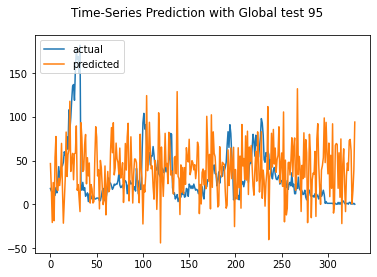

Test MAE: 41.126
Test RMSE: 51.360
Test sMAPE: 103.912
Test R Squared: -1.730
{'mae': 41.12567800120874, 'rmse': 51.360254393688905, 'smape': 103.91154030904634, 'r2': -1.7295831844041931}


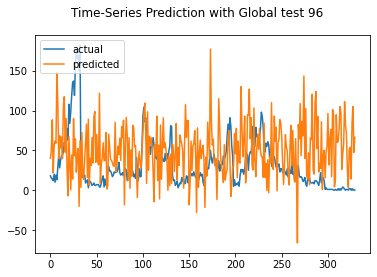

Test MAE: 43.758
Test RMSE: 53.987
Test sMAPE: 98.587
Test R Squared: -2.016
{'mae': 43.75810879703724, 'rmse': 53.98712773566535, 'smape': 98.58731134171394, 'r2': -2.0159382583456846}


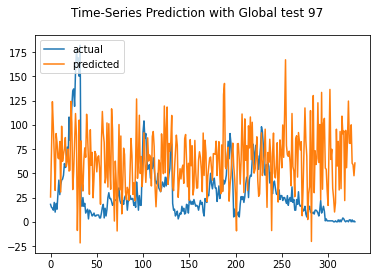

Test MAE: 45.250
Test RMSE: 54.077
Test sMAPE: 103.713
Test R Squared: -2.026
{'mae': 45.25046472766183, 'rmse': 54.07652750558549, 'smape': 103.71299810628929, 'r2': -2.025934990502335}


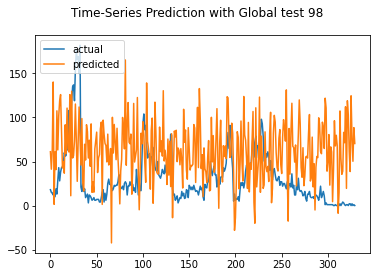

Test MAE: 50.876
Test RMSE: 60.914
Test sMAPE: 104.129
Test R Squared: -2.840
{'mae': 50.876333235249376, 'rmse': 60.91447751584544, 'smape': 104.12879567407656, 'r2': -2.8395740570607497}


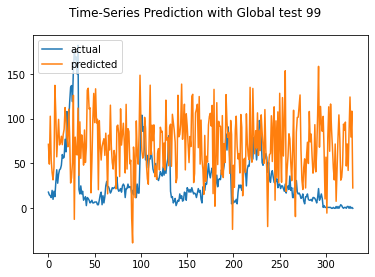

rmse : average=57.000, std=9.143
mae : average=47.726, std=9.579
smape : average=104.770, std=5.110
r2 : average=-2.449, std=1.136


([57.000481255467584, 9.143322874818677],
 [47.7263028580438, 9.578784731370007],
 [104.76977837204882, 5.11030266859802],
 [-2.4485171269733494, 1.1360314487689442])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')